<a href="https://colab.research.google.com/github/AnandKhandekar/Introduction-to-PyMC3/blob/master/Intro_to_PyMC3_1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exercise 2 : Linear Regression**

* produce an artificial DATA setrepresetnign 2 variables drawn from a NORMAL distribution corellated with each other by a simple linear relationship.

* We will then fit a Linear Regression model, to ESTIMATE the coeffiient of X and the intercept.

* We wil also introduce the concepts of 'ppc' Posterior Predictive checks'

In [1]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

     |████████████████████████████████| 1.4MB 2.2MB/s 
     |████████████████████████████████| 4.1MB 24.6MB/s 
     |████████████████████████████████| 327kB 37.2MB/s 
     |████████████████████████████████| 911kB 2.8MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [0]:

%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['retina']
plt.rc('font', size=12)
plt.style.use('seaborn-darkgrid')

First, we generate some data X which is drawn form a simple NORMAL distribution with mean $\mu = 1$ and sd $\sigma = 0.1$.

We also add amodel NOISE also drawn from a NORMAL distriution with mean 0 and sd 0.1.

and the obs_y is defined as 

```
obs_y = (0.65 * X) + 0.5 + noise
```
The Goal of the MODEL is to reverse engineer the beta co efficient and what is the alpha intercept.




In [0]:
 #1. generate the artificial dataset.
N = 10000

noise = np.random.normal(0.0, 0.1, N)
X = np.random.normal(1.0, 0.1, N)
obs_y = (0.65 * X) + 0.5 + noise     # obs_y = ( beta*X) _ intercept + noise

We EXPECT that y  follows a NORMAL distribution

```
y = pm.Normal('y', mu=expected_value, sd=stdev, observed=obs_y)
```
we link it to th observed data ' obs_y'. Now we are not just fitting data but we also care about the way two variables are related. This is acieved by defining the mean  mu of y as the expectd_value

```
expected_value = (X * coeff) + intercept
```
We will try to estimate the coeff and the intercept . the stdev parameter represents the noise here.

Again, like ususal the PRIOR on stdev is HalfNormal. The intercept can be positive or negative.





Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, intercept, stdev]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:17<00:00, 87.77it/s]
The acceptance probability does not match the target. It is 0.8824385385014225, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9118520611724251, but should be close to 0.8. Try to increase the number of tuning steps.
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

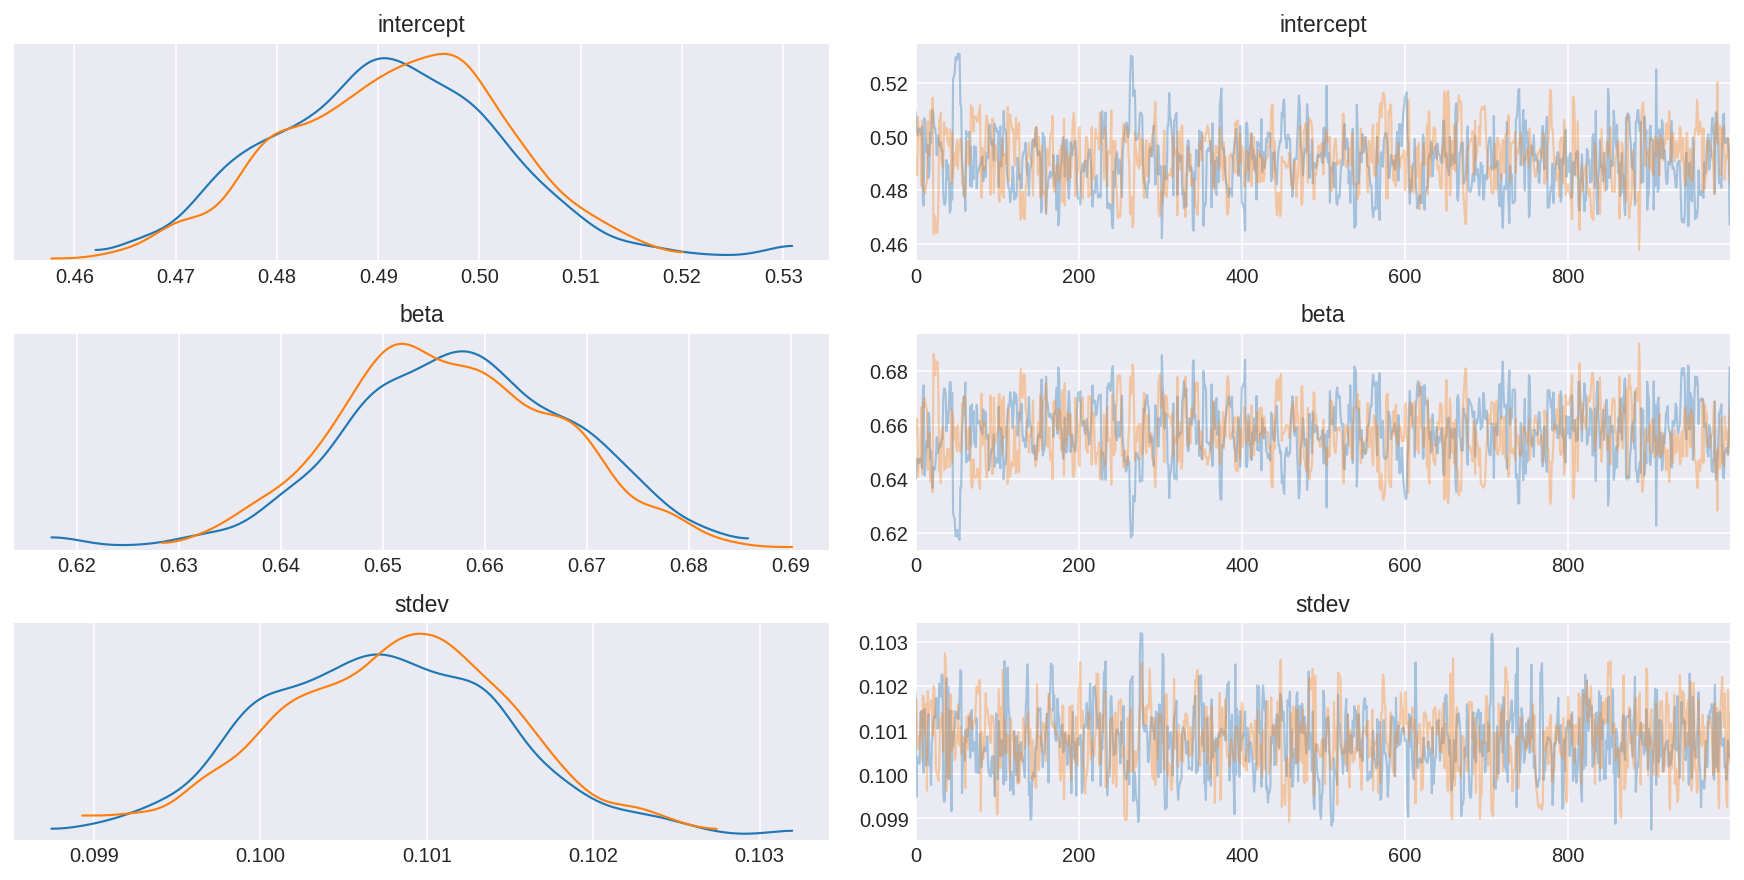

In [5]:
# 2. model that data with a simple regression model
with pm.Model() as exercise2:

    stdev = pm.HalfNormal('stdev', sd=1.)
    intercept = pm.Normal('intercept', mu=0.0, sd=1.)
    coeff = pm.Normal('beta', mu=0.5, sd=1.)

    expected_value = (X * coeff) + intercept
    y = pm.Normal('y', mu=expected_value, sd=stdev, observed=obs_y)

    trace = pm.sample(1000)    # fit the data

    pm.traceplot((trace), ['intercept','beta','stdev']) # plot the trace
    plt.show()

intercept which was estimated to be aroud 0.5 looks correct, the Beta ( coeff)which was estimated around 0.65 looks corrct as well and the stdev which is the noise in the model estimated as 0.1 also checks.

**Predictions** . Now we have a MODEL and lets try and make predictions based on the same training data. In the net exercisee w can show how to do predictions on out of sample DATA i.e. using new data.

**Important Point** :  we take the MEAN of each 1000 data point on axis = 0 of y_preds





In [6]:
# predictions suinf TRAINING data for now
with exercise2:

    ppc= pm.sample_ppc(trace, samples= 1000) # NOTE this will be deprecated and to be replace with sample_posterior_predictive

    # for each of values of X we will gey 1000 estimates slightly different due to uncertainty of the mean of the parameters.
    y_preds = ppc['y']
    print( "y_preds shape = ", ppc['y'].shape)

    # Same thing, but now using the expectation
    expected_y_pred = np.reshape(np.mean(y_preds, axis=0), [-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:04<00:00, 247.53it/s]

y_preds shape =  (1000, 10000)


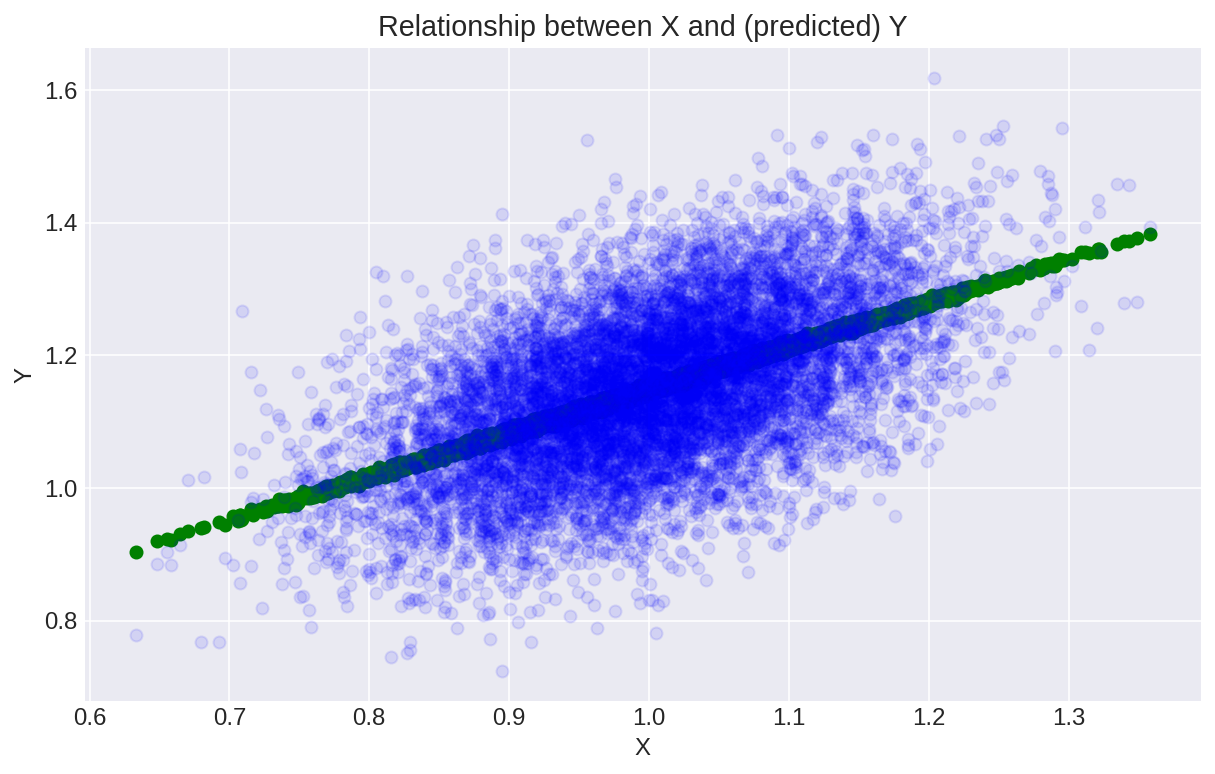

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(X, expected_y_pred, c='g')    # estimates  of the Regression lines.
plt.scatter(X, obs_y, c='b', alpha=0.1)  # Blue is the actual DATA 
plt.title("Relationship between X and (predicted) Y")
plt.xlabel("X")
plt.ylabel("Y")

plt.show()